# Install required packages

In [1]:
%pip install transformers datasets
%pip install pandas
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import transformers


/Users/carstenschnober/opt/anaconda3/envs/SoS/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [3]:
from pathlib import Path


DATA_DIR = Path("/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris")
assert DATA_DIR.is_dir()


In [4]:
ANP_DIR = DATA_DIR / "ANP" / "CleanFiles_perYear"
assert ANP_DIR.is_dir()


## ANP

In [33]:
from tqdm import tqdm


FILE_GLOB = "ANP_19[0-9][0-9].csv.gz"
ENCODING = "iso8859_15"


texts = pd.concat(
    tqdm(
        (
            pd.read_csv(f, compression="gzip", sep=";", encoding=ENCODING).dropna(
                subset="content"
            )
            for f in ANP_DIR.glob(FILE_GLOB)
        ),
        total=len(list(ANP_DIR.glob(FILE_GLOB))),
        unit="file",
        desc="Reading",
    ),
    ignore_index=True,
).convert_dtypes()

texts["decade"] = texts.apply(lambda row: int(row["year"] / 10) * 10, axis=1)


texts


Reading: 100%|██████████| 47/47 [00:15<00:00,  3.01file/s]


,filename,content,date,year,month,day,issue,decade
0,anp_1952_01_01_10_ocr.xml,Red.: Datum: veldman 1-1-52 Tijd: 13 ttt^....,01-01-1952,1952,1,1,10,1950
1,anp_1952_01_01_11_ocr.xml,Red. Datum: Tijd: Onderwerp: veltmeijer 1...,01-01-1952,1952,1,1,11,1950
2,anp_1952_01_01_12_ocr.xml,/3* Red. Datum: Tijd: Onderwerp: veltmei...,01-01-1952,1952,1,1,12,1950
3,anp_1952_01_01_13_ocr.xml,Red.: Datum: Tijd: Onderwerp: veltmeijer ...,01-01-1952,1952,1,1,13,1950
4,anp_1952_01_01_14_ocr.xml,Red.: Datum: Tijd: Onderwerp: mallon 1-1-...,01-01-1952,1952,1,1,14,1950
...,...,...,...,...,...,...,...,...
1472501,anp_1973_12_31_96_ocr.xml,Red.: Datum: Tijd: Onderwerp: kreek 31. 12. 7...,12-31-1973,1973,12,31,96,1970
1472502,anp_1973_12_31_97_ocr.xml,Red.: Datum: Tijd: Onderwerp: kuy 31-12-...,12-31-1973,1973,12,31,97,1970
1472503,anp_1973_12_31_98_ocr.xml,Red. Datum: Tijd: Onderwerp: kreek 31. 12...,12-31-1973,1973,12,31,98,1970
1472504,anp_1973_12_31_99_ocr.xml,Red. Datum: Tijd: Onderwerp: zijl 31-12-...,12-31-1973,1973,12,31,99,1970


Text(0, 0.5, 'Number of Documents')

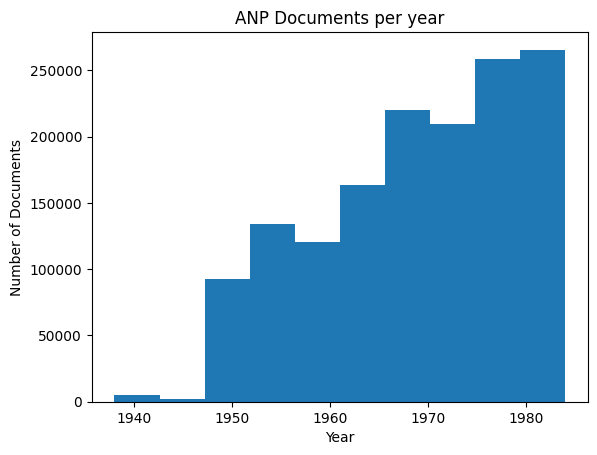

In [34]:
plt.hist(texts.year, label="Year")
plt.title("ANP Documents per year")
plt.xlabel("Year")
plt.ylabel("Number of Documents")


Text(0.5, 0, 'Number of Characters')

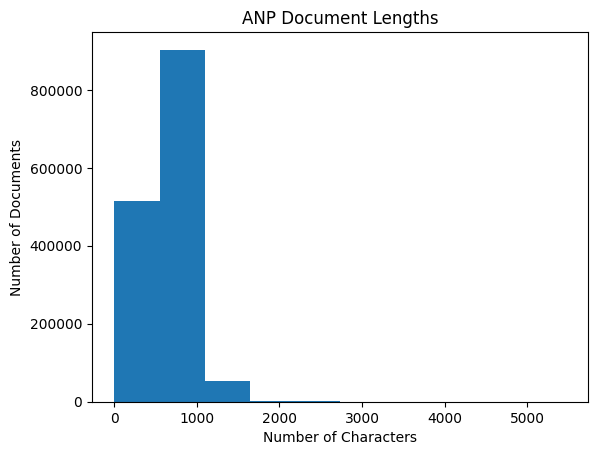

In [35]:
plt.hist(texts.content.str.len())
plt.title("ANP Document Lengths")
plt.ylabel("Number of Documents")
plt.xlabel("Number of Characters")


# Load Model

In [36]:
MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled"  # NL MODEL TODO: is the model trained on lowercased data?


In [37]:
from transformers import AutoTokenizer, pipeline
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# model = RobertaModel.from_pretrained(MODEL_NAME)

# FIXME: cannot use pipeline for extracting layers other than the last one
model: FeatureExtractionPipeline = pipeline(
    "feature-extraction", model=MODEL_NAME, tokenizer=tokenizer
)


Some weights of the model checkpoint at DTAI-KULeuven/robbertje-1-gb-non-shuffled were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at DTAI-KULeuven/robbertje-1-gb-non-shuffled and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this mode

# Compute Embeddings

In [38]:
TERM = "duurzaamheid"



In [39]:
term_token_ids = model.tokenizer(TERM)["input_ids"]
print(term_token_ids)

print(model.tokenizer.convert_ids_to_tokens(term_token_ids))


[0, 6395, 8262, 2]
['<s>', 'duur', 'zaamheid', '</s>']


In [40]:
texts[TERM] = texts.content.str.contains(TERM)


In [41]:
texts.loc[texts[TERM]]


,filename,content,date,year,month,day,issue,decade,duurzaamheid
28957,anp_1976_01_07_39_ocr.xml,Red.: cas Datum: 7-1-76 Tijd: Onderwerp: ...,07-01-1976,1976,1,7,39,1970,True
83532,anp_1968_02_22_59_ocr.xml,Red.: Datu m: Tijd: Onderwerp: ..meij. e...,02-22-1968,1968,2,22,59,1960,True
171251,anp_1950_09_03_61_ocr.xml,Cremers zondagweekoverzicht 3. 9*50 Het bese...,03-09-1950,1950,9,3,61,1950,True
338005,anp_1983_02_10_117_ocr.xml,Red.: ser Datum: 10-2-83 Tijd: 11. 00 Ond...,10-02-1983,1983,2,10,117,1980,True
338103,anp_1983_02_10_53_ocr.xml,Red. ser Datum: 10-2-83 Tijd: 11. 00 Onde...,10-02-1983,1983,2,10,53,1980,True
363292,anp_1983_07_13_128_ocr.xml,Red.: Datum: Tijd: Onderwerp: spa 13 7 83 !<....,07-13-1983,1983,7,13,128,1980,True
363338,anp_1983_07_13_3_ocr.xml,Red.: spa 13 ? 83 Tijd: Ond^Werp: o. e. ...,07-13-1983,1983,7,13,3,1980,True
435255,anp_1970_12_19_65_ocr.xml,Red. Datum: Tijd: Onderwerp: ..r. ei. jn ...,12-19-1970,1970,12,19,65,1970,True
564721,anp_1972_02_23_101_ocr.xml,Red. Datu m: Tijd: Onderwerp: jansen 23...,02-23-1972,1972,2,23,101,1970,True
594448,anp_1972_10_09_90_ocr.xml,Red.: Datum: Tijd: Onderwerp: cas 9-10-7...,09-10-1972,1972,10,9,90,1970,True


In [42]:
i = 29237
_text = texts.iloc[i].content

print(_text)


 Red.:  Datum:  Tijd:  Onderwerp:  eo  9-1-76  11  sport  ^*- 1. Badmrbnton - de nederlandse bond krijgt pa3HE3n6aiMMMHHC voor 4^ 2. het eerst de beschikking over een trainer en coach. Per ^ 3. / februari is de 92 28-jarige deen Steen Soerensen aangetrokken, + 4. die binnenkort een contract voor 2^ jaar zal tekenen/ / / V 5. Soerensen zal/om het nederlandse/spelpeil te verhogen de opleiding van trainers verzorge/\^n ook zelf trainingen geven 6. 7. 8. 9. 10. * 11. 12. -= 13. 14. 15. Bron: ^P Regels: 6  


In [43]:
token_ids = model.tokenizer(_text)["input_ids"]

for token_id, token in zip(token_ids, model.tokenizer.convert_ids_to_tokens(token_ids)):
    print(token_id, token)


0 <s>
4212 ĠRed
5385 .:
1200 Ġ
8205 ĠDatum
30 :
1200 Ġ
4587 ĠTijd
30 :
1200 Ġ
21263 ĠOnderwerp
30 :
1200 Ġ
300 Ġe
169 o
1200 Ġ
513 Ġ9
19 -
170 1
19 -
4767 76
1200 Ġ
715 Ġ11
1200 Ġ
908 Ġsport
1200 Ġ
27180 Ġ^
1586 *
19 -
82 Ġ1
4 .
7370 ĠBad
182 m
501 r
235 b
119 n
4505 ton
73 Ġ-
5 Ġde
7820 Ġnederlandse
7860 Ġbond
397 Ġkrijgt
14649 Ġpa
219 3
14733 HE
219 3
119 n
411 6
2577 ai
21514 MM
302 M
365 H
12376 HC
16 Ġvoor
158 Ġ4
12894 ^
93 Ġ2
4 .
10 Ġhet
451 Ġeerst
5 Ġde
2298 Ġbeschikking
44 Ġover
9 Ġeen
4336 Ġtrainer
8 Ġen
4429 Ġcoach
4 .
2657 ĠPer
27180 Ġ^
109 Ġ3
4 .
433 Ġ/
1293 Ġfebruari
12 Ġis
5 Ġde
12505 Ġ92
1297 Ġ28
19 -
1271 jarige
5 Ġde
155 en
9745 ĠSteen
203 ĠS
5811 oeren
592 sen
13194 Ġaangetrokken
6 ,
1305 Ġ+
158 Ġ4
4 .
21 Ġdie
3224 Ġbinnenkort
9 Ġeen
2348 Ġcontract
16 Ġvoor
93 Ġ2
12894 ^
70 Ġjaar
105 Ġzal
4477 Ġtekenen
68 /
433 Ġ/
433 Ġ/
272 ĠV
177 Ġ5
4 .
203 ĠS
5811 oeren
592 sen
105 Ġzal
68 /
595 om
10 Ġhet
7820 Ġnederlandse
68 /
2185 spel
17045 peil
14 Ġte
4329 Ġverhogen
5 Ġde
1143

Text(0, 0.5, 'Number of Documents')

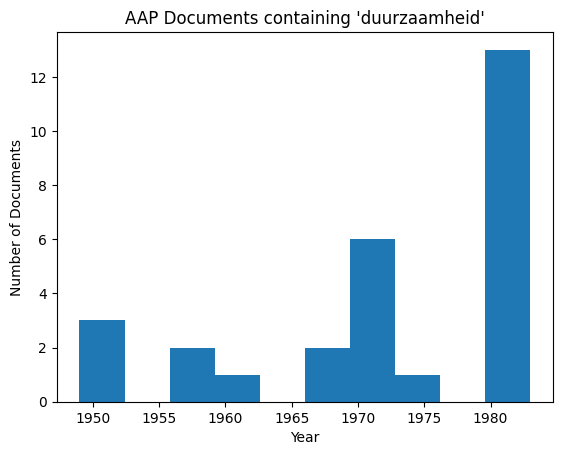

In [44]:
plt.hist(texts.loc[texts.content.str.contains(TERM)].year)
plt.title(f"AAP Documents containing '{TERM}'")
plt.xlabel("Year")
plt.ylabel("Number of Documents")


In [45]:
import importlib
import src

importlib.reload(src)

from src import Sentence

texts.loc[texts[TERM], "Sentence"] = texts.loc[texts[TERM]].apply(
    lambda row: Sentence(row["content"], model, row["year"], row["filename"]),
    axis=1,
)

texts


,filename,content,date,year,month,day,issue,decade,duurzaamheid,Sentence
0,anp_1952_01_01_10_ocr.xml,Red.: Datum: veldman 1-1-52 Tijd: 13 ttt^....,01-01-1952,1952,1,1,10,1950,False,NaN
1,anp_1952_01_01_11_ocr.xml,Red. Datum: Tijd: Onderwerp: veltmeijer 1...,01-01-1952,1952,1,1,11,1950,False,NaN
2,anp_1952_01_01_12_ocr.xml,/3* Red. Datum: Tijd: Onderwerp: veltmei...,01-01-1952,1952,1,1,12,1950,False,NaN
3,anp_1952_01_01_13_ocr.xml,Red.: Datum: Tijd: Onderwerp: veltmeijer ...,01-01-1952,1952,1,1,13,1950,False,NaN
4,anp_1952_01_01_14_ocr.xml,Red.: Datum: Tijd: Onderwerp: mallon 1-1-...,01-01-1952,1952,1,1,14,1950,False,NaN
...,...,...,...,...,...,...,...,...,...,...
1472501,anp_1973_12_31_96_ocr.xml,Red.: Datum: Tijd: Onderwerp: kreek 31. 12. 7...,12-31-1973,1973,12,31,96,1970,False,NaN
1472502,anp_1973_12_31_97_ocr.xml,Red.: Datum: Tijd: Onderwerp: kuy 31-12-...,12-31-1973,1973,12,31,97,1970,False,NaN
1472503,anp_1973_12_31_98_ocr.xml,Red. Datum: Tijd: Onderwerp: kreek 31. 12...,12-31-1973,1973,12,31,98,1970,False,NaN
1472504,anp_1973_12_31_99_ocr.xml,Red. Datum: Tijd: Onderwerp: zijl 31-12-...,12-31-1973,1973,12,31,99,1970,False,NaN


In [46]:
texts.loc[texts["Sentence"].notna()]

,filename,content,date,year,month,day,issue,decade,duurzaamheid,Sentence
28957,anp_1976_01_07_39_ocr.xml,Red.: cas Datum: 7-1-76 Tijd: Onderwerp: ...,07-01-1976,1976,1,7,39,1970,True,Sentence(text=' Red.: cas Datum: 7-1-76 Tijd...
83532,anp_1968_02_22_59_ocr.xml,Red.: Datu m: Tijd: Onderwerp: ..meij. e...,02-22-1968,1968,2,22,59,1960,True,Sentence(text=' Red.: Datu m: Tijd: Onderw...
171251,anp_1950_09_03_61_ocr.xml,Cremers zondagweekoverzicht 3. 9*50 Het bese...,03-09-1950,1950,9,3,61,1950,True,"Sentence(text="" Cremers zondagweekoverzicht 3...."
338005,anp_1983_02_10_117_ocr.xml,Red.: ser Datum: 10-2-83 Tijd: 11. 00 Ond...,10-02-1983,1983,2,10,117,1980,True,Sentence(text=' Red.: ser Datum: 10-2-83 Ti...
338103,anp_1983_02_10_53_ocr.xml,Red. ser Datum: 10-2-83 Tijd: 11. 00 Onde...,10-02-1983,1983,2,10,53,1980,True,Sentence(text=' Red. ser Datum: 10-2-83 Tij...
363292,anp_1983_07_13_128_ocr.xml,Red.: Datum: Tijd: Onderwerp: spa 13 7 83 !<....,07-13-1983,1983,7,13,128,1980,True,Sentence(text=' Red.: Datum: Tijd: Onderwerp: ...
363338,anp_1983_07_13_3_ocr.xml,Red.: spa 13 ? 83 Tijd: Ond^Werp: o. e. ...,07-13-1983,1983,7,13,3,1980,True,"Sentence(text="" Red.: spa 13 ? 83 Tijd: On..."
435255,anp_1970_12_19_65_ocr.xml,Red. Datum: Tijd: Onderwerp: ..r. ei. jn ...,12-19-1970,1970,12,19,65,1970,True,"Sentence(text="" Red. Datum: Tijd: Onderwerp..."
564721,anp_1972_02_23_101_ocr.xml,Red. Datu m: Tijd: Onderwerp: jansen 23...,02-23-1972,1972,2,23,101,1970,True,Sentence(text=' Red. Datu m: Tijd: Onderwe...
594448,anp_1972_10_09_90_ocr.xml,Red.: Datum: Tijd: Onderwerp: cas 9-10-7...,09-10-1972,1972,10,9,90,1970,True,Sentence(text=' Red.: Datum: Tijd: Onderwer...


In [47]:
texts["embeddings"] = texts.loc[texts["Sentence"].notna()].apply(
    lambda row: row["Sentence"].embeddings_matrix(TERM), axis=1
)
texts.loc[texts["embeddings"].notna()]


,filename,content,date,year,month,day,issue,decade,duurzaamheid,Sentence,embeddings
28957,anp_1976_01_07_39_ocr.xml,Red.: cas Datum: 7-1-76 Tijd: Onderwerp: ...,07-01-1976,1976,1,7,39,1970,True,Sentence(text=' Red.: cas Datum: 7-1-76 Tijd...,"[[0.025340180844068527, 0.0973568931221962, 0...."
83532,anp_1968_02_22_59_ocr.xml,Red.: Datu m: Tijd: Onderwerp: ..meij. e...,02-22-1968,1968,2,22,59,1960,True,Sentence(text=' Red.: Datu m: Tijd: Onderw...,"[[-0.27710914611816406, 0.28737807273864746, -..."
171251,anp_1950_09_03_61_ocr.xml,Cremers zondagweekoverzicht 3. 9*50 Het bese...,03-09-1950,1950,9,3,61,1950,True,"Sentence(text="" Cremers zondagweekoverzicht 3....","[[0.32683679461479187, 0.2526993751525879, -0...."
338005,anp_1983_02_10_117_ocr.xml,Red.: ser Datum: 10-2-83 Tijd: 11. 00 Ond...,10-02-1983,1983,2,10,117,1980,True,Sentence(text=' Red.: ser Datum: 10-2-83 Ti...,"[[0.10254843533039093, -0.04931650310754776, -..."
338103,anp_1983_02_10_53_ocr.xml,Red. ser Datum: 10-2-83 Tijd: 11. 00 Onde...,10-02-1983,1983,2,10,53,1980,True,Sentence(text=' Red. ser Datum: 10-2-83 Tij...,"[[0.5021758079528809, 0.12269017100334167, -0...."
363292,anp_1983_07_13_128_ocr.xml,Red.: Datum: Tijd: Onderwerp: spa 13 7 83 !<....,07-13-1983,1983,7,13,128,1980,True,Sentence(text=' Red.: Datum: Tijd: Onderwerp: ...,"[[0.30946338176727295, 0.1836877465248108, -0...."
363338,anp_1983_07_13_3_ocr.xml,Red.: spa 13 ? 83 Tijd: Ond^Werp: o. e. ...,07-13-1983,1983,7,13,3,1980,True,"Sentence(text="" Red.: spa 13 ? 83 Tijd: On...","[[0.18053409457206726, -0.0619555339217186, -0..."
435255,anp_1970_12_19_65_ocr.xml,Red. Datum: Tijd: Onderwerp: ..r. ei. jn ...,12-19-1970,1970,12,19,65,1970,True,"Sentence(text="" Red. Datum: Tijd: Onderwerp...","[[-0.3447812497615814, 0.12266619503498077, -0..."
564721,anp_1972_02_23_101_ocr.xml,Red. Datu m: Tijd: Onderwerp: jansen 23...,02-23-1972,1972,2,23,101,1970,True,Sentence(text=' Red. Datu m: Tijd: Onderwe...,"[[-0.5472287535667419, 0.6872007250785828, 0.1..."
594448,anp_1972_10_09_90_ocr.xml,Red.: Datum: Tijd: Onderwerp: cas 9-10-7...,09-10-1972,1972,10,9,90,1970,True,Sentence(text=' Red.: Datum: Tijd: Onderwer...,"[[-0.08458370715379715, 0.14093522727489471, -..."


In [48]:
# Candidate sentences with no actual matches for the term

texts.loc[texts["embeddings"].str.len() == 0]


,filename,content,date,year,month,day,issue,decade,duurzaamheid,Sentence,embeddings


In [49]:
indices = []
embeddings = []

for row in texts.loc[texts.Sentence.notna()].itertuples():
    for embedding in row.Sentence.embeddings_matrix(TERM):
        indices.append(row.Index)
        embeddings.append(embedding)


In [50]:
embeddings = np.array(embeddings)

assert embeddings.shape[1] == model.model.config.hidden_size

embeddings.shape

(33, 768)

# Plot

In [51]:
import umap.plot

umap.plot.output_notebook()

title = f"UMAP Embeddings Projections for '{TERM}'"

Loading BokehJS ...

## Static

In [52]:
mapper = umap.UMAP().fit(embeddings)


In [53]:
texts.loc[indices, "x"] = mapper.embedding_[:, 0]
texts.loc[indices, "y"] = mapper.embedding_[:, 1]
texts.loc[indices]


,filename,content,date,year,month,day,issue,decade,duurzaamheid,Sentence,embeddings,x,y
28957,anp_1976_01_07_39_ocr.xml,Red.: cas Datum: 7-1-76 Tijd: Onderwerp: ...,07-01-1976,1976,1,7,39,1970,True,Sentence(text=' Red.: cas Datum: 7-1-76 Tijd...,"[[0.025340180844068527, 0.0973568931221962, 0....",2.186600,5.812800
83532,anp_1968_02_22_59_ocr.xml,Red.: Datu m: Tijd: Onderwerp: ..meij. e...,02-22-1968,1968,2,22,59,1960,True,Sentence(text=' Red.: Datu m: Tijd: Onderw...,"[[-0.27710914611816406, 0.28737807273864746, -...",2.668576,5.938077
171251,anp_1950_09_03_61_ocr.xml,Cremers zondagweekoverzicht 3. 9*50 Het bese...,03-09-1950,1950,9,3,61,1950,True,"Sentence(text="" Cremers zondagweekoverzicht 3....","[[0.32683679461479187, 0.2526993751525879, -0....",2.200211,4.388906
338005,anp_1983_02_10_117_ocr.xml,Red.: ser Datum: 10-2-83 Tijd: 11. 00 Ond...,10-02-1983,1983,2,10,117,1980,True,Sentence(text=' Red.: ser Datum: 10-2-83 Ti...,"[[0.10254843533039093, -0.04931650310754776, -...",4.439067,3.889600
338005,anp_1983_02_10_117_ocr.xml,Red.: ser Datum: 10-2-83 Tijd: 11. 00 Ond...,10-02-1983,1983,2,10,117,1980,True,Sentence(text=' Red.: ser Datum: 10-2-83 Ti...,"[[0.10254843533039093, -0.04931650310754776, -...",4.439067,3.889600
338103,anp_1983_02_10_53_ocr.xml,Red. ser Datum: 10-2-83 Tijd: 11. 00 Onde...,10-02-1983,1983,2,10,53,1980,True,Sentence(text=' Red. ser Datum: 10-2-83 Tij...,"[[0.5021758079528809, 0.12269017100334167, -0....",4.107211,3.835443
338103,anp_1983_02_10_53_ocr.xml,Red. ser Datum: 10-2-83 Tijd: 11. 00 Onde...,10-02-1983,1983,2,10,53,1980,True,Sentence(text=' Red. ser Datum: 10-2-83 Tij...,"[[0.5021758079528809, 0.12269017100334167, -0....",4.107211,3.835443
363292,anp_1983_07_13_128_ocr.xml,Red.: Datum: Tijd: Onderwerp: spa 13 7 83 !<....,07-13-1983,1983,7,13,128,1980,True,Sentence(text=' Red.: Datum: Tijd: Onderwerp: ...,"[[0.30946338176727295, 0.1836877465248108, -0....",2.939888,5.011409
363338,anp_1983_07_13_3_ocr.xml,Red.: spa 13 ? 83 Tijd: Ond^Werp: o. e. ...,07-13-1983,1983,7,13,3,1980,True,"Sentence(text="" Red.: spa 13 ? 83 Tijd: On...","[[0.18053409457206726, -0.0619555339217186, -0...",2.467479,5.147342
435255,anp_1970_12_19_65_ocr.xml,Red. Datum: Tijd: Onderwerp: ..r. ei. jn ...,12-19-1970,1970,12,19,65,1970,True,"Sentence(text="" Red. Datum: Tijd: Onderwerp...","[[-0.3447812497615814, 0.12266619503498077, -0...",2.893221,4.424975


Text(0.5, 1.0, "UMAP Embeddings Projections for 'duurzaamheid'")

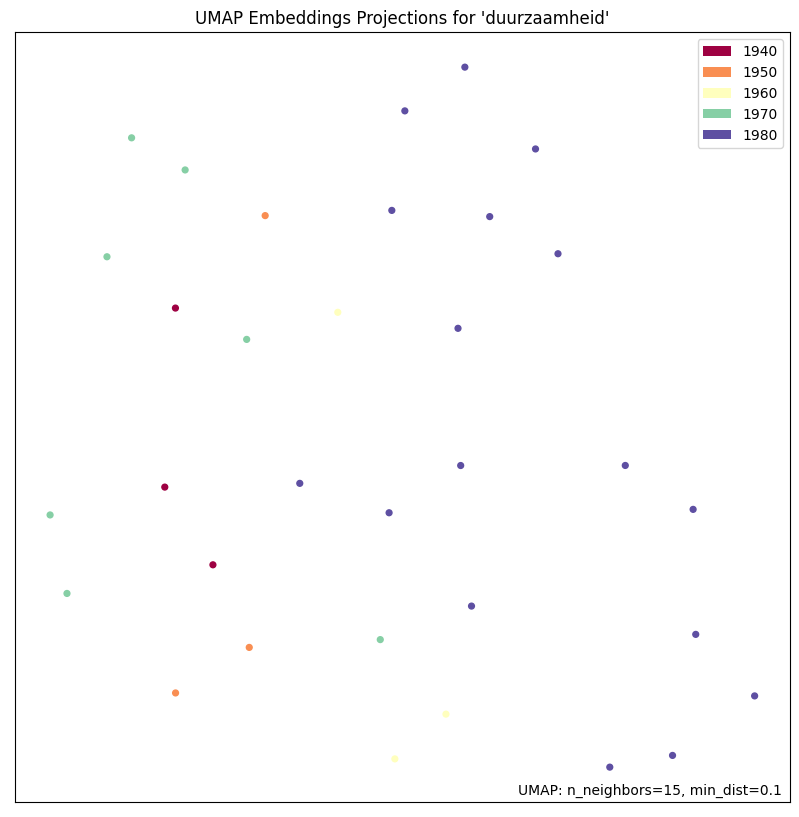

In [54]:
subplot = umap.plot.points(mapper, height=1000, width=1000, labels=texts.loc[indices]["decade"])
subplot.set_title(title)


## Interactive

In [55]:
from bokeh.models import ColumnDataSource

source = ColumnDataSource(
    data=texts.loc[indices][["content", "year", "filename", "decade", "x", "y"]].to_dict("list")
)
source


ColumnDataSource(id='1004', ...)

In [56]:
from bokeh.palettes import d3
from bokeh.models import CategoricalColorMapper
import bokeh.palettes

categories = texts.decade.unique()
palette = bokeh.palettes.Category20[len(categories)]

assert len(palette) >= len(
    categories
), f"Palette has only {len(palette)} categories, but {len(categories)} needed."

color_mapper = CategoricalColorMapper(
    factors=[str(c) for c in categories], palette=palette
)
color_mapper


CategoricalColorMapper(id='1009', ...)

In [57]:
from bokeh.models.tickers import SingleIntervalTicker
from bokeh.plotting import figure, show

p = figure(
    height=1000,
    width=1000,
    tooltips=[("doc", "@doc"), ("text", "@content"), ("year", "@year")],
)
p.title = title

# TODO: group by decade to enable muting decades individually via legend
p.dot(
    x="x",
    y="y",
    legend_field="decade",
    source=source,
    size=20,
    color={"field": "decade", "transform": color_mapper},
)

p.legend.click_policy = "mute"

p.xaxis.ticker = SingleIntervalTicker(desired_num_ticks=0)
p.yaxis.ticker = SingleIntervalTicker(desired_num_ticks=0)

# FIXME: empty ploy
show(p)
